Compare BP marginals with montecarlo

In [6]:
using Graphs
using Plots
using Printf
include("../sis.jl")
include("../inference/inference.jl")
include("../bp_fast.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [21]:
q = q_sis
T = 5
N = 16
k = 4
gg = random_regular_graph(N, k)
t = SimpleGraph(prim_mst(gg))
g = IndexedGraph(t)
@assert !is_cyclic(g)
# g = IndexedGraph(gg)
λ = 0.2
κ = 0.1
γ = 3/N
nobs = N÷2;

In [22]:
# sis = SIS(g, λ, κ, T; γ)
# bp = mpdbp(deepcopy(sis), d=1)
# cb = CB_BP(bp)
# x = draw_node_observations!(bp, nobs; last_time=true, softinf=1e2)
# ns = 10^7
# sms = sample(bp, ns)
# b_mc = marginals(sms)
# p_mc = [[bbb[2] for bbb in bb] for bb in b_mc];

In [23]:
function kl_marginals_bp_bondsize(T::Integer, N::Integer, k::Integer, λ::Real, κ::Real, γ::Real, 
        nobs::Integer, bonddims::AbstractVector{Int}; 
        ns_mc = 5*10^6, require_convergence=true, maxiter=100, tol=1e-3, kw...)
    b_bp = [Vector{Vector{Float64}}[] for _ in bonddims]
    
    gg = random_regular_graph(N, k)
    t = SimpleGraph(prim_mst(gg))
    g = IndexedGraph(t)
    @assert !is_cyclic(g)
    
    sis = SIS(g, λ, κ, T; γ)
    bp = mpdbp(deepcopy(sis), d=1)
    cb = CB_BP(bp)
    x = draw_node_observations!(bp, nobs; last_time=true, softinf=1e2)
    sms = sample(bp, ns_mc)
    b_mc_ = marginals(sms)
    b_mc = [[getproperty.(p, :val) for p in bi] for bi in b_mc_]
    
    for j in eachindex(bonddims)
        svd_trunc = TruncBond(bonddims[j])
        reset_messages!(bp)
        cb = CB_BP(bp; showprogress=false)
        iters, ε = iterate!(bp; maxiter, svd_trunc, cb, tol)
        if require_convergence
            iters == maxiter && error("BP did not converge")
        end
        b_bp[j] = beliefs(bp)
    end
    kls = [kl_marginals(b, b_mc) for b in b_bp]
end

kl_marginals_bp_bondsize (generic function with 1 method)

In [38]:
bonddims = [2, 4, 8];

In [39]:
kls_bp = Vector{Vector{Float64}}[];

In [ ]:
ninstances = 300
for n in 1:ninstances
    println("### instance $n of $ninstances")
    kl_ = kl_marginals_bp_bondsize(T, N, k, λ, κ, γ, nobs, bonddims, ns_mc=10^6)
    push!(kls_bp, kl_)
    flush(stdout)
end

### instance 1 of 300


SoftMargin sampling...   9%|██▊                          |  ETA: 0:01:22

In [ ]:
kls_bp_avg = map(eachindex(bonddims)) do i
    mean([a[i] for a in kls_bp])
end
kls_bp_std = map(eachindex(bonddims)) do i
    std([a[i] for a in kls_bp]) ./ sqrt(length(kls_bp))
end; 

SIS with: P(S→I)=λ=0.2, P(I→S)=κ=0.1. P(zero patient)=γ=0.1875
Random regular N=16, k=4. T=5, 8 random observations from the prior at final time
Average over 300 random instances.


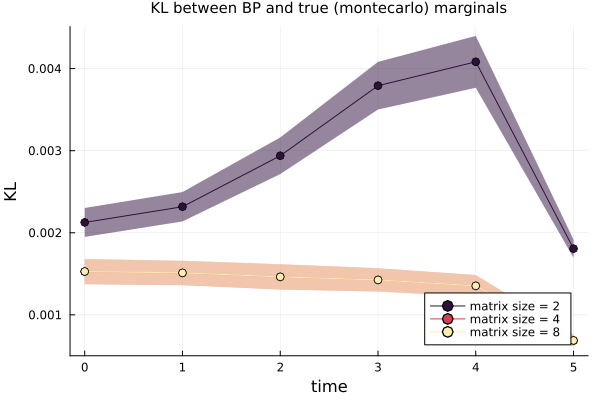

In [43]:
println("SIS with: P(S→I)=λ=$λ, P(I→S)=κ=$κ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=$k. T=$T, $nobs random observations from the prior at final time")
println("Average over ", length(kls_bp), " random instances.")
using ColorSchemes
cg = cgrad(:matter, length(bonddims), categorical=true) |> reverse
pl = plot(xlabel="time", ylabel="KL", xticks=0:T, legend=:bottomright)
for i in eachindex(bonddims)
    plot!(pl, 0:T, kls_bp_avg[i], ribbon=kls_bp_std[i], c=cg[i],
        label="matrix size = $(bonddims[i])", m=:o)
end
plot(pl, title="KL between BP and true (montecarlo) marginals", titlefontsize=10)